In [1]:
import numpy as np
from scipy.spatial import KDTree
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Load image and display it

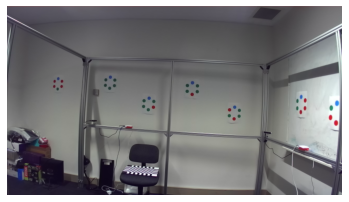

In [2]:
img = cv2.imread("camera 11/2022_12_15_15_51_19_927_rgb_left.png")

image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis("off")
plt.show()

# Rough target detection

## 1.1 Get the mask of the images

In [3]:
# get the min and max of rgb channels
img_c_min = img.min(axis=2)
img_c_max = img.max(axis=2)

(-0.5, 1279.5, 719.5, -0.5)

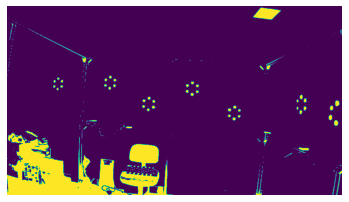

In [4]:
# calculate the Mask M
t_mincolor = 50
t_diffcolor = 50

M1 = (img_c_min < t_mincolor)
M2 = (img_c_max - img_c_min) > t_diffcolor

M = np.logical_or(M1, M2)

M = M.astype(np.uint8)

plt.imshow(M)
plt.axis("off")


(-0.5, 1279.5, 719.5, -0.5)

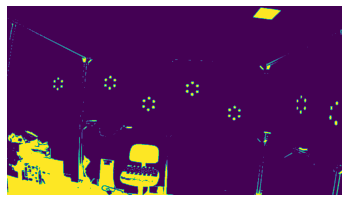

In [5]:
# display the mask gotten by condition one
plt.imshow(M1)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

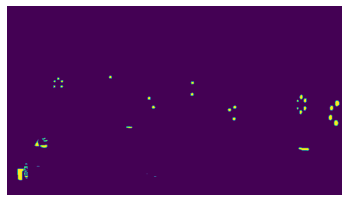

In [6]:
# display the mask gotten by condition two
plt.imshow(M2)
plt.axis("off")

## 1.2 Connected Components Analysis (CCA) to filter unwanted components

(-0.5, 1279.5, 719.5, -0.5)

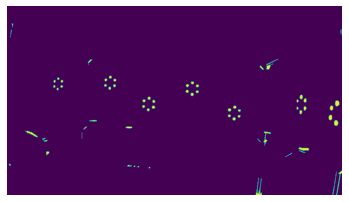

In [7]:
# Using the area to remove the very large and small clusters
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(M)

# for label in range(1, num_labels):
#     # 提取组件的统计信息
#     left = stats[label, cv2.CC_STAT_LEFT]
#     top = stats[label, cv2.CC_STAT_TOP]
#     width = stats[label, cv2.CC_STAT_WIDTH]
#     height = stats[label, cv2.CC_STAT_HEIGHT]
#     area = stats[label, cv2.CC_STAT_AREA]
#     centroid_x = centroids[label, 0]
#     centroid_y = centroids[label, 1]
    
#     # 打印组件的统计信息
#     print("Label:", label)
#     print("Bounding box:", (left, top, width, height))
#     print("Area:", area)
#     print("Centroid:", (centroid_x, centroid_y))
#     print()

# set the min and max area threshold
t_min_area = 20
t_max_area = 450

# filter the connection components
filtered_labels = np.zeros_like(labels)

for label in range(1, num_labels):
    area = stats[label, cv2.CC_STAT_AREA]

    if t_min_area <= area <= t_max_area:
        filtered_labels[labels == label] = 255
        
# change the image to binary image
filtered_M = np.where(filtered_labels == 255, 255, 0).astype(np.uint8)

plt.imshow(filtered_M)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

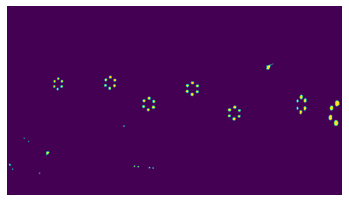

In [8]:
# Using the axis ratio to remove clusters that are obviously not round
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(M)

# set the min and max area threshold
t_min_area = 10
t_max_area = 450
t_axisRatio = 0.4

# filter the connection components
filtered_labels = np.zeros_like(labels)

filtered_labels_list = []

for label in range(1, num_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    
    left = stats[label, cv2.CC_STAT_LEFT]
    top = stats[label, cv2.CC_STAT_TOP]
    width = stats[label, cv2.CC_STAT_WIDTH]
    height = stats[label, cv2.CC_STAT_HEIGHT]
    
    # get current connected area mask
    connected_area_mask  = np.zeros_like(M)
    connected_area_mask[top:(top + height),left:(left + width)] = 1
    connected_area_mask = np.logical_and(M, connected_area_mask)
    # extract pixel coordinates of the connected area
    indices = np.where(connected_area_mask != 0)
    x_coords = indices[0]
    y_coords = indices[1]
    
    # Calculate covariance matrix， note that if connected_area_mask has only on elements, we should ignore it
    if x_coords.shape[0] > 1:
        pixel_coordinates = np.vstack((x_coords, y_coords))
        covariance_matrix = np.cov(pixel_coordinates)
        # Calculate the eigenvalues and eigenvectors
#         eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        eigenvalues = np.linalg.eigvals(covariance_matrix)
        # Take the square root of the eigenvalues
        sqrt_eigenvalues = np.sqrt(eigenvalues)
#         sqrt_eigenvalues = sqrt_eigenvalues
        # Get delta_min and delat_max 
        delta_min = sqrt_eigenvalues.min()
        delta_max = sqrt_eigenvalues.max()
        axis_ratio = delta_min / delta_max
    else:
        axis_ratio = 0.0
    
#     print("label:", label, " area:", area, " indices_num:", x_coords.shape[0], " delta_min:", delta_min, " delta_max:", delta_max)
    
    if t_min_area <= area and area <= t_max_area and axis_ratio > t_axisRatio:
        filtered_labels[labels == label] = 255
        filtered_labels_list.append(label)
        
# change the image to binary image
filtered_M = np.where(filtered_labels == 255, 255, 0).astype(np.uint8)

plt.imshow(filtered_M)
plt.axis("off")

In [9]:
filtered_labels_list
num_labels

318

## 1.3 Construct the ellipse matrix and filter unwanted targets

In [10]:
# Step 1: get the 5 nearest clusters of each selected cluster 
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_M)

# Build a KDTree from the centroids points
kdtree = KDTree(centroids)
# Find the 5 nearest neighbors for each point
distances, indices = kdtree.query(centroids, k=6)  # k+1 to include the point itself

# define the function to get the matrix A

def get_derivative_matrix(x, y):
    return np.array([x * x, x*y, y * y])


# Calculate each group of clusters coordinate & the matrix A
derivate_matrix_set = np.zeros((centroids.shape[0], 6, 3))

for idx in range(centroids.shape[0]):
    mean_value = centroids[indices[idx]].mean(axis=0)
    matrix_A = np.zeros((6,3))
    for cluster_idx in range(6):
        x, y = centroids[indices[idx,cluster_idx]] - mean_value
        matrix_A[cluster_idx] = get_derivative_matrix(x, y)
        
    derivate_matrix_set[idx] = matrix_A
    

In [11]:
num_labels
# labels.min(), labels.max()

53

In [12]:
one_vector = np.ones(6)
def get_largest_residual_error(matrix_A):
    
    ellips_params = (np.linalg.inv(matrix_A.T @ matrix_A)) @ matrix_A.T @ one_vector
#     print(ellips_params)
    
    residual_errors = matrix_A @ ellips_params - one_vector
    
    #  print(residual_errors)
    residual_errors = np.abs(residual_errors)
#     print(residual_errors)

    return residual_errors.max()


In [13]:
selected_cluster_sets =set()

target_num_list = []

t_ellipse = 0.2

# filter these clusters that can form a target

for idx in range(centroids.shape[0]):
    # if the cluster has been selected, ignore it
    if idx in selected_cluster_sets:
        continue
    matrix_A =derivate_matrix_set[idx]
    residual_errors = get_largest_residual_error(matrix_A)
    print("residual_errors", residual_errors)
    
    if residual_errors < t_ellipse:
        selected_cluster_sets.update(indices[idx])
        target_num_list.append(idx)
        
   

residual_errors 0.7242413706903479
residual_errors 0.3863901997056429
residual_errors 0.016917887417908117
residual_errors 0.031512672699426814
residual_errors 0.011295548560400603
residual_errors 0.07219442363444639
residual_errors 0.009785762919749197
residual_errors 0.752419220709027
residual_errors 0.020713688244937245
residual_errors 0.7524192207090267
residual_errors 0.7002487906482714
residual_errors 0.7002487906482714
residual_errors 0.9291558328923427
residual_errors 0.2154749564509445
residual_errors 0.2154749564509445
residual_errors 0.21547495645094683
residual_errors 0.2154749564509446
residual_errors 0.7943923281520138
residual_errors 0.7943923281520138
residual_errors 0.7943923281520138
residual_errors 0.7943923281520138
residual_errors 0.2154749564509446
residual_errors 0.21547495645094683


(-0.5, 1279.5, 719.5, -0.5)

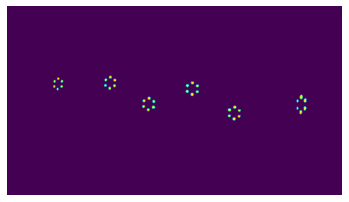

In [14]:
# review the finally selected clusters 

# filter the connection components
filtered_labels = np.zeros_like(labels)

for label_idx in selected_cluster_sets:
    filtered_labels[labels == label_idx] = 255
    
# change the image to binary image
filtered_M = np.where(filtered_labels == 255, 255, 0).astype(np.uint8)

plt.imshow(filtered_M)
plt.axis("off")

In [40]:
target_num_list

[2, 3, 8, 20, 21, 29]

In [41]:
indices

array([[ 0, 17, 19, 11, 25, 28],
       [ 1, 20, 24, 22, 32, 35],
       [ 2,  4,  5, 10,  9, 15],
       [ 3,  6,  7, 14, 13, 16],
       [ 4,  2,  9,  5, 15, 10],
       [ 5,  2, 10,  4, 15,  9],
       [ 6,  3, 13,  7, 16, 14],
       [ 7,  3, 14,  6, 16, 13],
       [ 8, 11, 12, 17, 18, 19],
       [ 9, 15,  4, 10,  2,  5],
       [10, 15,  5,  9,  2,  4],
       [11,  8, 17, 12, 19, 18],
       [12,  8, 18, 11, 19, 17],
       [13, 16,  6, 14,  3,  7],
       [14, 16,  7, 13,  3,  6],
       [15,  9, 10,  4,  5,  2],
       [16, 13, 14,  6,  7,  3],
       [17, 19, 11,  8, 18, 12],
       [18, 19, 12, 17,  8, 11],
       [19, 17, 18, 11, 12,  8],
       [20, 22, 24, 32, 31, 36],
       [21, 25, 23, 28, 27, 33],
       [22, 20, 24, 31, 32, 36],
       [23, 21, 27, 25, 33, 28],
       [24, 20, 32, 22, 31, 36],
       [25, 21, 28, 23, 33, 27],
       [26, 30, 38, 41, 22, 31],
       [27, 33, 23, 28, 21, 25],
       [28, 25, 33, 21, 27, 23],
       [29, 35, 34, 39, 37, 40],
       [30

# Detected target analysis

In [16]:
## 1. Analysis targets one by one, each target contains 6 clusters
clusters_idxes = indices[target_num_list[0]]

cluster_idx = clusters_idxes[0]

left = stats[cluster_idx, cv2.CC_STAT_LEFT]
top = stats[cluster_idx, cv2.CC_STAT_TOP]
width = stats[cluster_idx, cv2.CC_STAT_WIDTH]
height = stats[cluster_idx, cv2.CC_STAT_HEIGHT]

# print((top, left, width, height))

# get current connected area mask
connected_area_mask  = np.zeros_like(filtered_M)
connected_area_mask[top:(top + height),left:(left + width)] = 1
connected_area_mask = np.logical_and(filtered_M, connected_area_mask)

masked_img = image_rgb * connected_area_mask[:, :, np.newaxis]

# split RGB channel values
red_channel = masked_img[:,:,0]
green_channel = masked_img[:,:,1]
blue_channel = masked_img[:,:,2]

# calculate the sum of each channel values
red_sum = np.sum(red_channel)
green_sum = np.sum(green_channel)
blue_sum = np.sum(blue_channel)

print(red_sum, green_sum, blue_sum)

3968 4954 9268


## Get the prodominated color of each cluster in a target

In [38]:
color_dict = {
    0: "R",
    1: "G",
    2: "B"
}

target_list = []

for target_idx in range(len(target_num_list)):
    clusters_idxes = indices[target_num_list[target_idx]]
    
    weighted_centroids = np.zeros((6, 2))

    total_mask = np.zeros_like(filtered_M)
    color_value_matrix = np.zeros((6, 3))

    for idx in range(clusters_idxes.shape[0]):
        cluster_idx = clusters_idxes[idx]
        
        # get the mask of current cluster
        connected_area_mask = (labels == cluster_idx).astype(np.uint8)
        
        
        # Dilate the selected information: can use different kernels
        kernel = np.ones((3, 3), np.uint8) # square kernel
        dilated_mask = cv2.dilate(connected_area_mask, kernel, iterations=1)        
#         print("original sum: ", connected_area_mask.sum(), " dilated sum: ", dilated_mask.sum())
        
        # get dilated image
        dilated_img = image_rgb * dilated_mask[:, :, np.newaxis]
        # compute the average value of RGB channels
        avg_rgb_value = np.sum(dilated_img, axis=(0,1)) / dilated_mask.sum()
        # compute the L2 norm of each pixel position
        avg_dilated_img = (dilated_img - avg_rgb_value) * dilated_mask[:, :, np.newaxis]
        l2_norm_avg_img = np.linalg.norm(avg_dilated_img, axis=2)
        # get the weighted of each pixel in the map
        weighted_p = 1 - l2_norm_avg_img /  l2_norm_avg_img.max()
        weighted_p = weighted_p * dilated_mask
        # compute the weighted centroid of this cluster
        dilated_indices = np.where(dilated_mask != 0)

        # Get the weighted dilated evaluation
        weighted_x, weighted_y = 0, 0
        for x, y in zip(dilated_indices[0], dilated_indices[1]):
            weighted_x += x * weighted_p[x, y]
            weighted_y += y * weighted_p[x, y]
        weighted_x = weighted_x / weighted_p.sum()
        weighted_y = weighted_y / weighted_p.sum()
        weighted_centroids[idx] = np.array([weighted_y, weighted_x])

        # for visualization 
        total_mask = np.logical_or(total_mask, connected_area_mask)

        masked_img = image_rgb * connected_area_mask[:, :, np.newaxis]

        # split RGB channel values
        red_channel = masked_img[:,:,0]
        green_channel = masked_img[:,:,1]
        blue_channel = masked_img[:,:,2]

        # calculate the sum of each channel values
        red_sum = np.sum(red_channel)
        green_sum = np.sum(green_channel)
        blue_sum = np.sum(blue_channel)

        color_value_matrix[idx] = np.array([red_sum, green_sum, blue_sum])
#         print(red_sum, green_sum, blue_sum)


    color_key_list = list(np.argmax(color_value_matrix, axis=1))
    color_list = [color_dict.get(key) for key in color_key_list]

    if color_list.count("B") != 1:
        print("This targets has some problem, ignore it:", color_list)
        continue

#     else:
#         print(color_list)

    # clockwise arrangement calculation
    blue_idx = color_list.index("B")
    blue_cluster_index = clusters_idxes[blue_idx]
    blue_centroid = centroids[blue_cluster_index]
    target_centroids = centroids[clusters_idxes]

    # calculate the polar coordinates angle of each point relative to the starting point
    angles = np.arctan2(target_centroids[:, 1] - blue_centroid[1], target_centroids[:, 0] - blue_centroid[0])

    # use argsort to sort angles，return the indexes of sorted value
    sorted_indices = np.argsort(angles)

    # get targe label
    rearraged_color_list = [color_list[idx] for idx in sorted_indices]
#     print(rearraged_color_list)
    target_label =  "".join(rearraged_color_list[1:])

    
    
    sorted_clusters_idxes = clusters_idxes[sorted_indices]
#     print("original cluster indices: ", clusters_idxes, " sorted cluster indices: ", sorted_clusters_idxes)
    sorted_weighted_centroids = weighted_centroids[sorted_indices]
#     print("target_label is ", target_label)
#     print(centroids[sorted_clusters_idxes])
#     print(sorted_weighted_centroids)
    
    
    target_dict = {}
    target_dict["key"] = target_label
    target_dict["cluster_idxes"] = sorted_clusters_idxes
    target_dict["original_centroids"] = centroids[sorted_clusters_idxes]
    target_dict["weighted_centroids"] = sorted_weighted_centroids
    
    target_list.append(target_dict)
    
    # compute the weighted centroids 

#     target_image = image_rgb * total_mask[:, :, np.newaxis]
#     fig = plt.figure(figsize=(10,10))
#     plt.imshow(target_image)
#     plt.axis("off")
#     plt.show()

['B', 'G', 'G', 'G', 'G', 'G']
['B', 'R', 'R', 'G', 'R', 'R']
['B', 'G', 'G', 'R', 'G', 'G']
['B', 'R', 'R', 'R', 'G', 'G']
['B', 'G', 'R', 'G', 'G', 'G']
['B', 'G', 'G', 'R', 'G', 'R']


In [44]:
np.sum(masked_img, axis=(0,1))

array([13672,  3794,  4999], dtype=uint32)

In [48]:
list("ABC")

['A', 'B', 'C']

In [32]:
# clusters_idxes = indices[target_num_list[0]]
# weighted_centroids = np.zeros((6, 2))

# total_mask = np.zeros_like(filtered_M)
# color_value_matrix = np.zeros((6, 3))

# for idx in range(clusters_idxes.shape[0]):
#     cluster_idx = clusters_idxes[idx]

#     connected_area_mask = (labels == cluster_idx).astype(np.uint8)
    
#     kernel = np.ones((3, 3), np.uint8)
    
#     # dilated operation
#     dilated_mask = cv2.dilate(connected_area_mask, kernel, iterations=1)
#     print("original sum: ", connected_area_mask.sum(), " dilated sum: ", dilated_mask.sum())
    
#     dilated_img = image_rgb * dilated_mask[:, :, np.newaxis]
    
#     avg_rgb_value = np.sum(dilated_img, axis=(0,1)) / dilated_mask.sum()

#     avg_dilated_img = (dilated_img - avg_rgb_value) * dilated_mask[:, :, np.newaxis]
#     l2_norm_avg_img = np.linalg.norm(avg_dilated_img, axis=2)
    
#     weighted_p = 1 - l2_norm_avg_img /  l2_norm_avg_img.max()
#     weighted_p = weighted_p * dilated_mask
#     # compute the weighted centroid of this cluster
    
#     dilated_indices = np.where(dilated_mask != 0)

    
#     weighted_x, weighted_y = 0, 0
#     for x, y in zip(dilated_indices[0], dilated_indices[1]):
# #         print("coordinate: ",x, y, weighted_p[x, y])
#         weighted_x += x * weighted_p[x, y]
#         weighted_y += y * weighted_p[x, y]
        
#     weighted_x = weighted_x / weighted_p.sum()
#     weighted_y = weighted_y / weighted_p.sum()
# #     print(weighted_x, weighted_y, weighted_p.sum())
    
#     weighted_centroids[idx] = np.array([weighted_y, weighted_x])

#     # get dilated_mask
#     total_mask = np.logical_or(total_mask, dilated_mask)
#     masked_img = image_rgb * connected_area_mask[:, :, np.newaxis]

#     # split RGB channel values
#     red_channel = masked_img[:,:,0]
#     green_channel = masked_img[:,:,1]
#     blue_channel = masked_img[:,:,2]

#     # calculate the sum of each channel values
#     red_sum = np.sum(red_channel)
#     green_sum = np.sum(green_channel)
#     blue_sum = np.sum(blue_channel)

#     color_value_matrix[idx] = np.array([red_sum, green_sum, blue_sum])
    
#     # compute the weighted centroids of 


# color_key_list = list(np.argmax(color_value_matrix, axis=1))
# color_list = [color_dict.get(key) for key in color_key_list]

# if color_list.count("B") != 1:
#     print("This targets has some problem, ignore it:", color_list)

# else:
#     print(color_list)



# # clockwise arrangement calculation
# blue_idx = color_list.index("B")
# blue_cluster_index = clusters_idxes[blue_idx]
# blue_centroid = centroids[blue_cluster_index]
# target_centroids = centroids[clusters_idxes]

# # calculate the polar coordinates angle of each point relative to the starting point
# angles = np.arctan2(target_centroids[:, 1] - blue_centroid[1], target_centroids[:, 0] - blue_centroid[0])

# # use argsort to sort angles，return the indexes of sorted value
# sorted_indices = np.argsort(angles)

# sorted_clusters_idxes = clusters_idxes[sorted_indices]
# sorted_weighted_centroids = weighted_centroids[sorted_indices]

# # get targe label
# rearraged_color_list = [color_list[idx] for idx in sorted_indices]
# print(rearraged_color_list)
# target_label =  "".join(rearraged_color_list[1:])

# print("target_label is ", target_label)
# print(centroids[sorted_clusters_idxes])
# print(sorted_weighted_centroids)

# target_image = image_rgb * total_mask[:, :, np.newaxis]
# fig = plt.figure(figsize=(10,10))
# plt.imshow(target_image)
# plt.axis("off")
# plt.show()

In [26]:
weighted_p

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
labels.min(), labels.max()

In [ ]:
blue_centroid

In [ ]:
list(np.argmax(color_value_matrix, axis=1))

In [ ]:
np.zeros((6,3))

In [ ]:
# masked_img = image_rgb * filtered_M[:, :, np.newaxis]


# plt.imshow(masked_img)
# plt.axis("off")
# plt.show()

In [56]:
import cv2
import numpy as np

# 定义棋盘格的大小
chessboard_size = (9, 6)

# 准备棋盘格角点的世界坐标
object_points = []  # 存储世界坐标系中的特征点坐标
image_points_left = []  # 存储左相机图像中的特征点坐标
image_points_right = []  # 存储右相机图像中的特征点坐标

# 生成棋盘格角点的世界坐标
object_points = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
object_points[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

# 生成左右相机的图像坐标
for i in range(chessboard_size[1]):
    for j in range(chessboard_size[0]):
        image_points_left.append([j, i])
        image_points_right.append([j + 2, i])

# 将特征点的坐标转换为数组
object_points = np.array([object_points])
image_points_left = np.array([image_points_left], dtype=np.float32)
image_points_right = np.array([image_points_right], dtype=np.float32)

# 定义相机矩阵和畸变系数的初始值
camera_matrix_left = np.eye(3)
camera_matrix_right = np.eye(3)
dist_coeffs_left = np.zeros(5)
dist_coeffs_right = np.zeros(5)

# 定义图像大小
image_size = (640, 480)

print(object_points.shape, image_points_left.shape)

# 进行立体校准
retval, camera_matrix_left, dist_coeffs_left, camera_matrix_right, dist_coeffs_right, R, T, E, F = cv2.stereoCalibrate(
    object_points, image_points_left, image_points_right, camera_matrix_left, dist_coeffs_left, camera_matrix_right,
    dist_coeffs_right, image_size, criteria=None, flags=cv2.CALIB_FIX_INTRINSIC
)

# 打印校准结果
print("左相机的相机矩阵：")
print(camera_matrix_left)
print("\n左相机的畸变系数：")
print(dist_coeffs_left)
print("\n右相机的相机矩阵：")
print(camera_matrix_right)
print("\n右相机的畸变系数：")
print(dist_coeffs_right)
print("\n旋转矩阵：")
print(R)
print("\n平移向量：")
print(T)
print("\n本征矩阵：")
print(E)
print("\n基础矩阵：")
print(F)


(1, 54, 3) (1, 54, 2)
左相机的相机矩阵：
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

左相机的畸变系数：
[0. 0. 0. 0. 0.]

右相机的相机矩阵：
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

右相机的畸变系数：
[0. 0. 0. 0. 0.]

旋转矩阵：
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

平移向量：
[[2.00000000e+00]
 [3.70911674e-17]
 [1.56570466e-17]]

本征矩阵：
[[ 0.00000000e+00 -1.56570466e-17  3.70911674e-17]
 [ 1.56570466e-17  0.00000000e+00 -2.00000000e+00]
 [-3.70911674e-17  2.00000000e+00  0.00000000e+00]]

基础矩阵：
[[ 0.00000000e+00 -1.56570466e-17  3.70911674e-17]
 [ 1.56570466e-17  0.00000000e+00 -2.00000000e+00]
 [-3.70911674e-17  2.00000000e+00  0.00000000e+00]]


左相机的相机矩阵：
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

左相机的畸变系数：
[0. 0. 0. 0. 0.]

右相机的相机矩阵：
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

右相机的畸变系数：
[0. 0. 0. 0. 0.]

旋转矩阵：
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

平移向量：
[[2.00000000e+00]
 [3.70911674e-17]
 [1.56570466e-17]]

本征矩阵：
[[ 0.00000000e+00 -1.56570466e-17  3.70911674e-17]
 [ 1.56570466e-17  0.00000000e+00 -2.00000000e+00]
 [-3.70911674e-17  2.00000000e+00  0.00000000e+00]]

基础矩阵：
[[ 0.00000000e+00 -1.56570466e-17  3.70911674e-17]
 [ 1.56570466e-17  0.00000000e+00 -2.00000000e+00]
 [-3.70911674e-17  2.00000000e+00  0.00000000e+00]]
三维重构结果：
Point 1 : [0. 0. 0.]
Point 2 : [0. 0. 0.]
Point 3 : [0. 0. 0.]
Point 4 : [0. 0. 0.]
Point 5 : [0. 0. 0.]
Point 6 : [0. 0. 0.]
Point 7 : [0. 0. 0.]
Point 8 : [0. 0. 0.]
Point 9 : [0. 0. 0.]
Point 10 : [0. 0. 0.]
Point 11 : [0. 0. 0.]
Point 12 : [0. 0. 0.]
Point 13 : [0. 0. 0.]
Point 14 : [0. 0. 0.]
Point 15 : [0. 0. 0.]
Point 16 : [0. 0. 0.]
Point 17 : [0. 0. 0.]
Point 18 : [0. 0. 0.]
Point 19 : [0. 0. 0.]
Poin

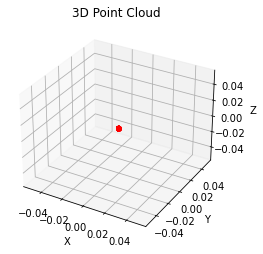

In [61]:
import cv2
import numpy as np

# 定义棋盘格的大小
chessboard_size = (9, 6)

# 准备棋盘格角点的世界坐标
object_points = []  # 存储世界坐标系中的特征点坐标
image_points_left = []  # 存储左相机图像中的特征点坐标
image_points_right = []  # 存储右相机图像中的特征点坐标

# 生成棋盘格角点的世界坐标
for i in range(chessboard_size[1]):
    for j in range(chessboard_size[0]):
        object_points.append([j, i, 0])

# 生成左右相机的图像坐标
for i in range(chessboard_size[1]):
    for j in range(chessboard_size[0]):
        image_points_left.append([j, i])
        image_points_right.append([j + 2, i])

# 转换特征点坐标为数组
object_points = np.array([object_points], dtype=np.float32)
image_points_left = np.array([image_points_left], dtype=np.float32)
image_points_right = np.array([image_points_right], dtype=np.float32)

# 定义相机矩阵和畸变系数的初始值
camera_matrix_left = np.eye(3)
camera_matrix_right = np.eye(3)
dist_coeffs_left = np.zeros(5)
dist_coeffs_right = np.zeros(5)

# 进行立体校准
retval, camera_matrix_left, dist_coeffs_left, camera_matrix_right, dist_coeffs_right, R, T, E, F = cv2.stereoCalibrate(
    object_points, image_points_left, image_points_right, camera_matrix_left, dist_coeffs_left, camera_matrix_right,
    dist_coeffs_right, imageSize=(640, 480), criteria=None, flags=cv2.CALIB_FIX_INTRINSIC
)

# 打印校准结果
print("左相机的相机矩阵：")
print(camera_matrix_left)
print("\n左相机的畸变系数：")
print(dist_coeffs_left)
print("\n右相机的相机矩阵：")
print(camera_matrix_right)
print("\n右相机的畸变系数：")
print(dist_coeffs_right)
print("\n旋转矩阵：")
print(R)
print("\n平移向量：")
print(T)
print("\n本征矩阵：")
print(E)
print("\n基础矩阵：")
print(F)

# 定义左右相机的投影矩阵
P1 = np.hstack((camera_matrix_left, np.zeros((3, 1))))
P2 = np.hstack((camera_matrix_right, np.zeros((3, 1))))

# 定义左右相机中对应的特征点坐标
imagePoints1_homogeneous = cv2.convertPointsToHomogeneous(image_points_left)
imagePoints2_homogeneous = cv2.convertPointsToHomogeneous(image_points_right)

# 进行三维重构
points4D_homogeneous = cv2.triangulatePoints(P1, P2, image_points_left[0].T, image_points_right[0].T)

# 转换为非齐次坐标形式
points3D = cv2.convertPointsFromHomogeneous(points4D_homogeneous.T)

# 打印三维重构结果
print("三维重构结果：")
for i, point in enumerate(points3D):
    print("Point", i+1, ":", point[0])

# 进行点云可视化（可选）
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 提取 X、Y、Z 坐标
X = points3D[:, 0, 0]
Y = points3D[:, 0, 1]
Z = points3D[:, 0, 2]

# 绘制点云
ax.scatter(X, Y, Z, c='r', marker='o')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图形标题
plt.title('3D Point Cloud')

# 显示图形
plt.show()


In [52]:
cv2.stereoCalibrateExtended?
